## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*


# 1. Install Dependencies and Setup

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img


from keras.models import Sequential
from keras.layers import Activation

from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from sklearn.metrics import classification_report
import keras.optimizers
from keras.applications import vgg16
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import cv2

## Dataset


In [2]:
# Get Dataset
!git clone  https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035
Receiving objects: 100% (3039/3039), 79.25 MiB | 20.32 MiB/s, done.
Updating files: 100% (3264/3264), done.


 Beyin tümörü sınıflandırma veri seti ile ilgili bazı sabitleri ve dosya yollarını tanımlıyor.

In [3]:
# Define necessary constants
TEST_DIR = '../content/Brain-Tumor-Classification-DataSet/Testing'
TRAIN_DIR = '../content/Brain-Tumor-Classification-DataSet/Training'
IMG_SIZE = 224
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

Bu kod parçası genellikle bir görüntü sınıflandırma modeli eğitimi için veri seti oluşturulması amacıyla kullanılır. Eğitim verileri, her bir sınıfa ait görüntülerin özelliklerini ve etiketlerini içerir. Bu veri seti daha sonra bir derin öğrenme modeliyle eğitilir.

In [4]:
# Creating training dataset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR,category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          training_data.append([new_array, class_num])

    random.shuffle(training_data)

create_training_data()
#np.save('train_data.npy', training_data)
print(len(training_data))

print("train")
print()
X_train = np.array([i[0] for i in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = [i[1] for i in training_data]

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("Y_train.pickle","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()

100%|██████████| 827/827 [00:02<00:00, 334.96it/s]


2870
train



In [5]:
# Creating testing dataset
testing_data = []

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          testing_data.append([new_array, class_num])

    random.shuffle(testing_data)

create_testing_data()
#np.save('testing_data.npy', testing_data)
print(len(testing_data))

print("testing")
print()
X_test= np.array([i[0] for i in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_test = [i[1] for i in testing_data]

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("Y_test.pickle","wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()

100%|██████████| 74/74 [00:00<00:00, 125.93it/s]


394
testing



In [6]:
train_glioma_dir = os.path.join(TRAIN_DIR, 'glioma_tumor')

train_meningioma_dir = os.path.join(TRAIN_DIR, 'meningioma_tumor')

train_no_dir = os.path.join(TRAIN_DIR, 'no_tumor')

train_pituitary_dir = os.path.join(TRAIN_DIR, 'pituitary_tumor')


# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_glioma_dir))} images of glioma_tumor for training.\n")
print(f"There are {len(os.listdir(train_meningioma_dir))} images of meningioma_tumor for training.\n")
print(f"There are {len(os.listdir(train_no_dir))} images of no_tumor for training.\n")
print(f"There are {len(os.listdir(train_pituitary_dir))} images of pituitary_tumor for training.\n")

There are 826 images of glioma_tumor for training.

There are 822 images of meningioma_tumor for training.

There are 395 images of no_tumor for training.

There are 827 images of pituitary_tumor for training.



In [7]:

test_glioma_dir = os.path.join(TEST_DIR, 'glioma_tumor')

test_meningioma_dir = os.path.join(TEST_DIR, 'meningioma_tumor')

test_no_dir = os.path.join(TEST_DIR, 'no_tumor')

test_pituitary_dir = os.path.join(TEST_DIR, 'pituitary_tumor')


# Check the number of images for each class and set
print(f"There are {len(os.listdir(test_glioma_dir))} images of glioma_tumor for testing.\n")
print(f"There are {len(os.listdir(test_meningioma_dir))} images of meningioma_tumor for testing.\n")
print(f"There are {len(os.listdir(test_no_dir))} images of no_tumor for testing.\n")
print(f"There are {len(os.listdir(test_pituitary_dir))} images of pituitary_tumor for testing.\n")

There are 100 images of glioma_tumor for testing.

There are 115 images of meningioma_tumor for testing.

There are 105 images of no_tumor for testing.

There are 74 images of pituitary_tumor for testing.



Şimdi sınıfların her birinin örnek görseline bir göz atın:

Sample glioma tumor image:


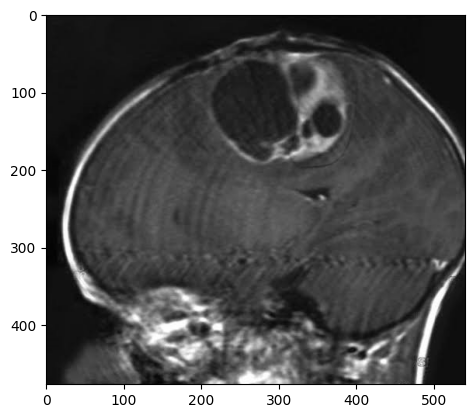

Sample meningioma tumor image:


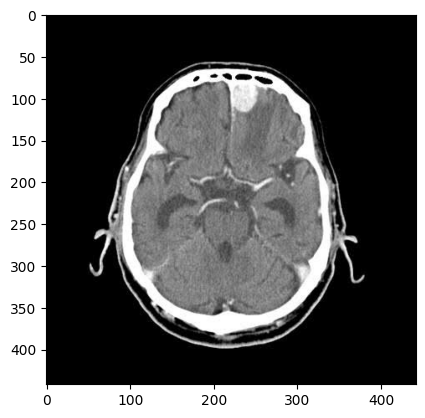

Sample no tumor image:


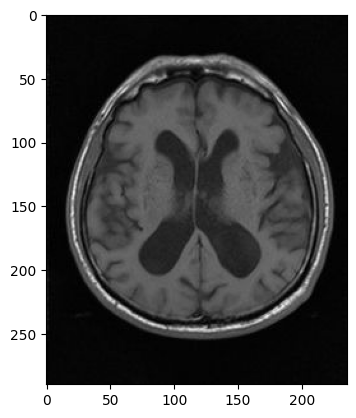

Sample pituitary tumor image:


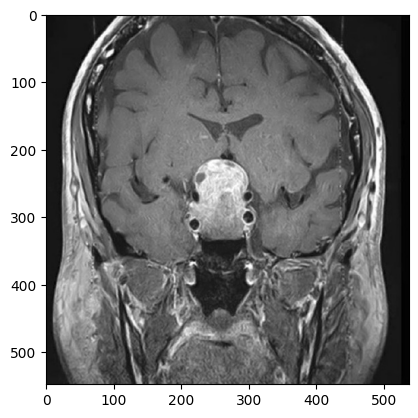

In [8]:
print("Sample glioma tumor image:")
plt.imshow(load_img(f"{os.path.join(test_glioma_dir, os.listdir(test_glioma_dir)[0])}"))
plt.show()

print("Sample meningioma tumor image:")
plt.imshow(load_img(f"{os.path.join(test_meningioma_dir, os.listdir(test_meningioma_dir)[0])}"))
plt.show()

print("Sample no tumor image:")
plt.imshow(load_img(f"{os.path.join(test_no_dir, os.listdir(test_no_dir)[0])}"))
plt.show()

print("Sample pituitary tumor image:")
plt.imshow(load_img(f"{os.path.join(test_pituitary_dir, os.listdir(test_pituitary_dir)[0])}"))
plt.show()



In [14]:
# Load the first example of a meningioma tumor
sample_image  = load_img(f"{os.path.join(test_meningioma_dir, os.listdir(test_meningioma_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (442, 442, 3)


In [9]:
# Load the first example of a glioma tumor
sample_image  = load_img(f"{os.path.join(test_glioma_dir, os.listdir(test_glioma_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (477, 541, 3)


In [31]:
# Load the first example of a pituitary tumor
sample_image  = load_img(f"{os.path.join(test_pituitary_dir, os.listdir(test_pituitary_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (548, 538, 3)


## Training and Validation Generators

Artık uğraştığınız görüntüleri bildiğinize göre, bu görüntüleri ağınıza besleyecek jeneratörleri kodlamanın zamanı geldi. Bunun için aşağıdaki 'train_val_generators' fonksiyonunu tamamlayın:


TensorFlow'un Keras API'sini kullanarak veri artırma (data augmentation) işlemlerini içeren eğitim ve test veri seti oluşturucularını tanımlar. Veri artırma, eğitim veri setindeki çeşitliliği artırmak için kullanılan bir tekniktir, bu sayede modelin daha genel ve daha iyi genelleme yapabilmesi hedeflenir.


In [10]:

def train_val_generators(TRAIN_DIR, TEST_DIR):

  # Instantiate the ImageDataGenerator class
  # Don't forget to normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest'
                                     )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  test_datagen = ImageDataGenerator(rescale = 1.0/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))

  return train_generator, test_generator

In [11]:
# Test your generators
train_generator ,test_generator = train_val_generators(TRAIN_DIR,TEST_DIR)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


Eğitim ve test setinin dağılımlarının grafiği

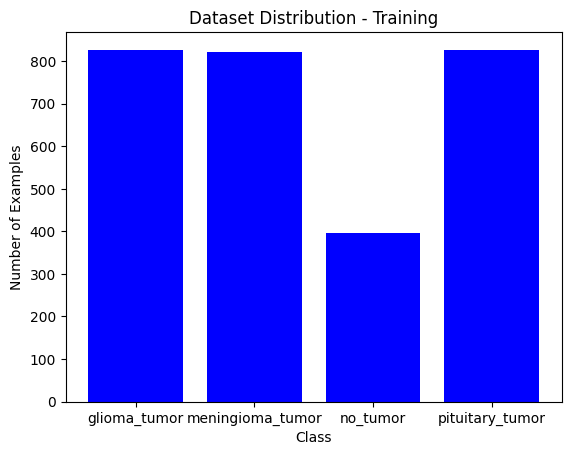

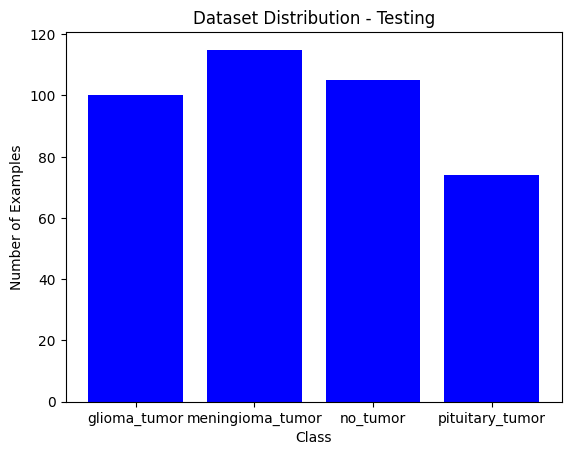

In [12]:
import matplotlib.pyplot as plt
import os

def plot_dataset_distribution(generator, dataset_name):
    # Veri seti dizininden sınıfları ve sayılarını al
    class_indices = generator.class_indices

    # Sınıf isimleri ve örnek sayıları
    class_names = list(class_indices.keys())
    num_examples = [len(os.listdir(os.path.join(generator.directory, str(class_folder)))) for class_folder in class_indices.keys()]

    # Çubuk grafik çizimi
    plt.bar(class_names, num_examples, color='blue')
    plt.title(f'Dataset Distribution - {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Number of Examples')
    plt.show()

# Eğitim veri seti dağılımını görselleştir
plot_dataset_distribution(train_generator, 'Training')

# Test veri seti dağılımını görselleştir
plot_dataset_distribution(test_generator, 'Testing')


Bir derin öğrenme modeli oluşturan ve derin öğrenme modelini derleyen bir fonksiyonu içerir. Model, bir evrişimli sinir ağı (Convolutional Neural Network - CNN) olarak tasarlanmıştır ve sınıflandırma görevi için kullanılmak üzere ayarlanmıştır.

In [13]:
def create_final_model():

  # Define the model

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3) , activation = 'relu', input_shape=(150,150,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024, activation = 'relu'),
      tf.keras.layers.Dense(4, activation = 'softmax')

  ])


  model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])




  return model

Bu kod parçası, oluşturulan modelin toplam parametre sayısını ve eğitilebilir parametre sayısını kontrol etmek için kullanılır. Bu bilgiler, modelin karmaşıklığını ve öğrenme sürecindeki ayarlanabilir parametre sayısını gösterir.





In [14]:
# Save your model in a variable
model = create_final_model()

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 179,443,588 total parameters in this model.
There are 179,443,588 trainable parameters in this model.


In [27]:
import tensorflow as tf
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": False})

 TensorFlow ve Keras kullanarak bir geri çağrı (callback) sınıfı tanımlamaktadır. Bu geri çağrı, eğitim sırasında her bir epoch (epoch sonu) tamamlandığında belirli bir koşulu kontrol eder ve belirli bir doğruluk (accuracy) eşiğine ulaşıldığında eğitimi durdurur.

In [15]:
# Define a Callback class that stops training once accuracy reaches 80.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80):
      print("\nReached 80.0% accuracy so cancelling training!")
      self.model.stop_training = True

**Train Model**

In [28]:
callbacks = myCallback()
model = create_final_model()
history = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
90/90 - 32s - loss: 3.2469 - accuracy: 0.3875 - val_loss: 2.4926 - val_accuracy: 0.2843 - 32s/epoch - 351ms/step
Epoch 2/100
90/90 - 23s - loss: 1.0848 - accuracy: 0.5115 - val_loss: 3.3079 - val_accuracy: 0.2665 - 23s/epoch - 251ms/step
Epoch 3/100
90/90 - 26s - loss: 1.0111 - accuracy: 0.5544 - val_loss: 2.7641 - val_accuracy: 0.3249 - 26s/epoch - 293ms/step
Epoch 4/100
90/90 - 22s - loss: 0.9475 - accuracy: 0.5923 - val_loss: 4.3972 - val_accuracy: 0.3249 - 22s/epoch - 243ms/step
Epoch 5/100
90/90 - 25s - loss: 0.9339 - accuracy: 0.6007 - val_loss: 4.6792 - val_accuracy: 0.2868 - 25s/epoch - 275ms/step
Epoch 6/100
90/90 - 26s - loss: 0.9017 - accuracy: 0.6118 - val_loss: 4.3508 - val_accuracy: 0.3071 - 26s/epoch - 286ms/step
Epoch 7/100
90/90 - 25s - loss: 0.8785 - accuracy: 0.6268 - val_loss: 3.5121 - val_accuracy: 0.3325 - 25s/epoch - 282ms/step
Epoch 8/100
90/90 - 23s - loss: 0.8360 - accuracy: 0.6474 - val_loss: 3.8544 - val_accuracy: 0.3122 - 23s/epoch - 254ms/step


In [16]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

NameError: ignored